# PID con autotuner (método de Hägglund–Åström)

Se simula el procedimiento de autotune por relé y el posterior control PID ajustado por la regla de Ziegler–Nichols.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl
from scipy.signal import find_peaks


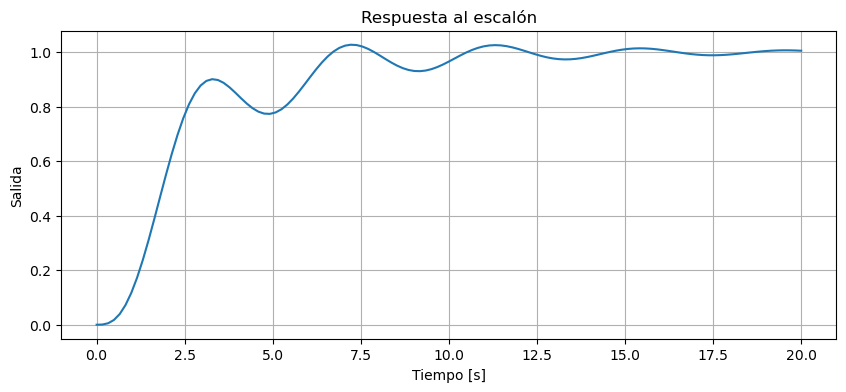

/tmp/ipykernel_1711079/2607523454.py:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_hist.append(float(y))
/tmp/ipykernel_1711079/2607523454.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_hist.append(float(u))


Analizando salida luego de transitorios t=26.7
Periodo de oscilación Tu =3.99
Periodo de oscilación w_u =1.57
Amplitud de oscilación Yp = 1.29
Ganancia crítica Ku = 0.99
[Autotune] Ku=0.990, Tu=3.990, PID: Kp=0.594, Ki=0.298, Kd=0.296


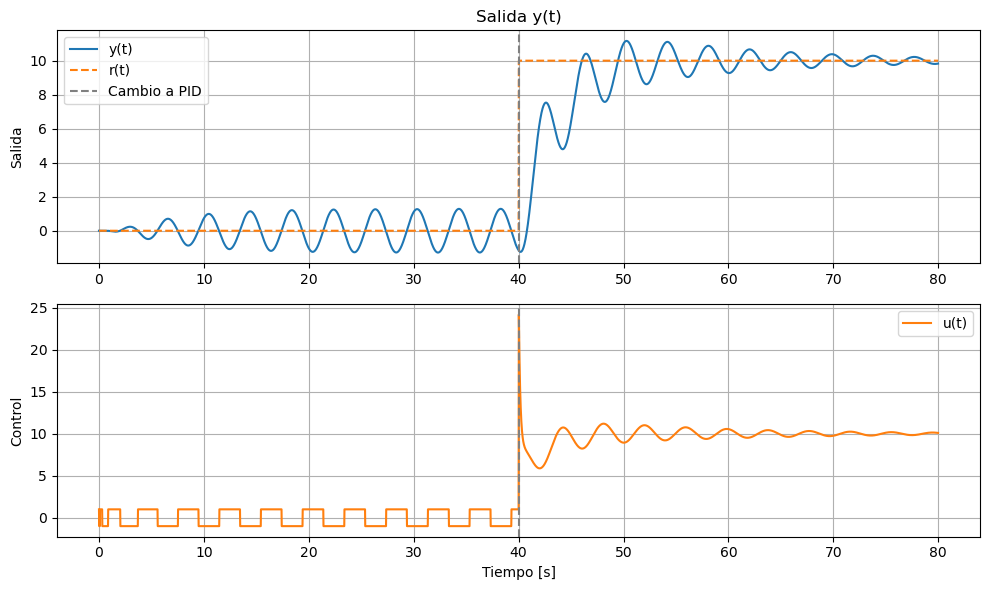

In [27]:
# *****************************************************
# Definición de la planta y parámetros de la simulación

Ts = 0.02          # periodo de muestreo
t_total = 80.0     # duración total [s]
h = 1.0            # amplitud del relé
t_autotune = 40.0  # duración del ensayo de relé
r = 10.0           # referencia luego del autotune

# Planta de orden 3 (puede sostener oscilaciones)
num = [1.0]
den = [1.0, 0.8, 2.5, 1.0]
G = ctrl.tf(num, den)

plt.figure(figsize=(10, 4))
t,y = ctrl.step_response(G, 20)
plt.plot(t,y)
plt.title("Respuesta al escalón")
plt.xlabel("Tiempo [s]")
plt.ylabel("Salida")
plt.grid(True)
plt.show()

# Discretización para el ensayo (Zero-Order Hold)
Gd = ctrl.tf2ss(ctrl.sample_system(G, Ts, method='zoh'))

# *****************************************************
# Simulación completa (AUTOTUNE + CONTROL PID)
x = np.zeros(Gd.B.shape[0])
y = 0.0
integ = 0.0
deriv = 0.0
prev_e = 0.0

t_hist, y_hist, u_hist, r_hist, mode_hist = [], [], [], [], []
autotuned = False

Kp = Ki = Kd = 0.0

for ti in np.arange(0, t_total, Ts):
    # Determinar referencia según fase
    if not autotuned:
        ref = 0.0
    else:
        ref = r  # referencia unitaria luego del autotune

    # Error
    e = ref - y

    # Control según modo
    if not autotuned:
        # Fase de relé
        u = h if e >= 0 else -h
    else:
        # Fase PID
        integ += e * Ts
        deriv = gamma/(gamma+Ts) * deriv + (e - prev_e) / (gamma+Ts)
        u = Kp * e + Ki * integ + Kd * deriv
    prev_e = e

    # Evolución del sistema
    x = np.dot(Gd.A, x) + (Gd.B * u).flatten()
    y = np.dot(Gd.C, x) + (Gd.D * u) #+ 0.002 * np.random.rand(1)

    # Guardar
    t_hist.append(ti)
    y_hist.append(float(y))
    r_hist.append(float(ref))
    u_hist.append(float(u))
    mode_hist.append(0 if not autotuned else 1)

    # Si termina el tiempo de autotune, obtener parámetros y cambiar a PID
    if not autotuned and ti >= t_autotune:
        idx0 = (2*len(y_hist))//3
        print(f"Analizando salida luego de transitorios t={t_hist[idx0]:.1f}")
        y_perm = y_hist[idx0:-1]
        u_perm = u_hist[idx0:-1]
        peaks, _ = find_peaks(y_perm)

        # promedio de distancia entre picos
        Tu = np.mean(np.diff(np.array(t_hist)[idx0+peaks]))  
        print(f"Periodo de oscilación Tu ={Tu:.2f}")
        print(f"Periodo de oscilación w_u ={2*np.pi/Tu:.2f}")

        a = (np.max(y_perm) - np.min(y_perm)) / 2
        print(f"Amplitud de oscilación Yp = {a:.2f}")
        Ku = 4*h / (np.pi * a)
        print(f"Ganancia crítica Ku = {Ku:.2f}")

        Ku = (4 * h) / (np.pi * a)
        Kp = 0.6 * Ku
        Ti = 0.5 * Tu
        Td = 0.125 * Tu
        Ki = Kp / Ti
        Kd = Kp * Td
        gamma = 0.3*Td
        autotuned = True
        print(f"[Autotune] Ku={Ku:.3f}, Tu={Tu:.3f}, PID: Kp={Kp:.3f}, Ki={Ki:.3f}, Kd={Kd:.3f}")

# *****************************************************
# Grafico resultados

t_hist = np.array(t_hist)
y_hist = np.array(y_hist)
u_hist = np.array(u_hist)
mode_hist = np.array(mode_hist)

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t_hist, y_hist, label='y(t)')
plt.plot(t_hist, r_hist, '--', label='r(t)')
plt.axvline(t_autotune, color='gray', linestyle='--', label='Cambio a PID')
plt.title("Salida y(t)")
plt.ylabel("Salida")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t_hist, u_hist, label='u(t)', color='tab:orange')
plt.axvline(t_autotune, color='gray', linestyle='--')
plt.xlabel("Tiempo [s]")
plt.ylabel("Control")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Autotuning: Identificación por mínimos cuadrados y ajuste por IMC

# Identified ARX coefficients:
a1 = -0.8893210532840156 a2 = -0.09222387988171772 b1 = 0.009250107854095094 b2 = 0.009250107854095038
<TransferFunction>: Planta identificada
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.05

    0.00925 z + 0.00925
  ------------------------
  z^2 - 0.8893 z - 0.09222
<TransferFunction>: sys[1095]$sampled
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.05

   0.006231
  ----------
  z - 0.9938
1 states have been removed from the model
Controlador por IMC: <TransferFunction>: sys[1104]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.05

  0.6736 z^2 - 0.599 z - 0.06212
  ------------------------------
      z^2 + 2.665e-14 z - 1
0 states have been removed from the model
<TransferFunction>: Sistema de LC
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.05

  1.389e-05 z^4 + 4.264e-05 z^3 - 3.657e-05 z^2 - 1.718e-05 z - 1.256e-06
  -----------------------------------------------------------------------
        z^5 - 2.955 z^4 + 1.916 z^3 + 1.994 z

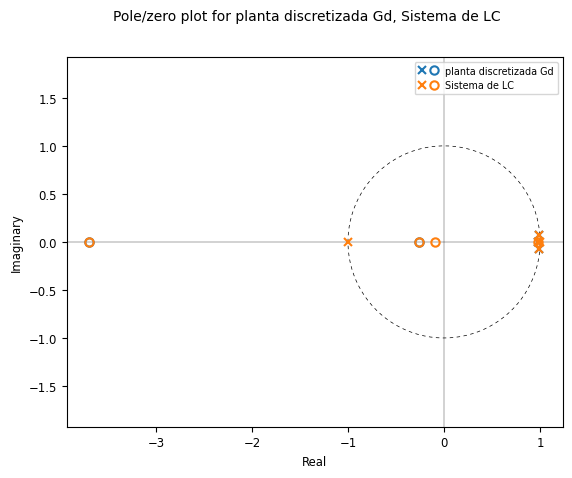

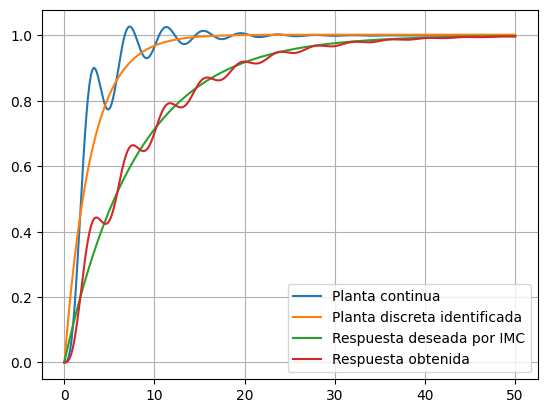

In [90]:
# PID with IMC tuning after ARX(2) identification
# ------------------------------------------------
# Código preparado por ChatGPT — NO EJECUTAR (el usuario pidió sólo el código).
# Explicación rápida:
# 1) Genera un experimento (PRBS) y simula la planta continua en abierto (muestreo DT)
# 2) Identifica un modelo ARX de orden 2 por mínimos cuadrados
# 3) Convierte el modelo identificado a un modelo continuo 2º orden reducido
# 4) Diseña un controlador IMC con filtro (lambda) y calcula el controlador equivalente
# 5) Aproxima dicho controlador IMC por una estructura PID con derivada filtrada
# 6) Ejecuta (en simulación) la primera parte como experimento abierto y la segunda
#    parte con el PID en lazo cerrado. Grafica y(t) y u(t) con una línea que indique
#    el instante de conmutación (fin del experimento de identificación -> inicio PID).

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
from scipy.optimize import least_squares
import control as ct

# -------------------------------
# Parámetros de la planta original
# -------------------------------
num = [1.0]
den = [1.0, 0.8, 2.5, 1.0]
#den = np.polymul([1,0.5],[1,0.9])
Gc = ct.tf(num, den)   # planta continua

# Muestreo para identificación / control discreto
Ts = 0.05              # s

# Discretizamos la planta para la etapa de identificación (ZOH)
Gd = ct.sample_system(Gc, Ts, method='zoh')
Gd.name='planta discretizada Gd'
ct.pzmap(Gd)

# ---------------------------------------------------
# 1) Generar experimento de identificación (PRBS)
# ---------------------------------------------------
N_id = 4000                      # cantidad de muestras del experimento
t_id = np.arange(N_id) * Ts

np.random.seed(0)
u_id = np.sign(np.random.rand(N_id))

# Simulamos la planta discreta con la señal de identificación
_, y_id = ct.forced_response(Gd, T=t_id, U=u_id)

# Añadimos ruido de medición (opcional)
noise_std = 0.002
y_id_noisy = y_id + noise_std * np.random.randn(len(y_id))

# ---------------------------------------------------
# 2) Identificación ARX(2,2) por mínimos cuadrados
#    modelo: y[k] = -a1 y[k-1] - a2 y[k-2] + b1 u[k-1] + b2 u[k-2]
# ---------------------------------------------------
na = 2
nb = 2

# Construcción de la matriz de regresores Phi y vector yvec (técnica clásico ARX)
N_eff = N_id - max(na, nb)
Phi = np.zeros((N_eff, na + nb))
yvec = np.zeros(N_eff)
for k in range(max(na, nb), N_id):
    row = []
    # salida pasada (con signo negativo según convención)
    for i in range(1, na + 1):
        row.append(-y_id_noisy[k - i])
    # entradas pasadas
    for j in range(1, nb + 1):
        row.append(u_id[k - j])
    Phi[k - max(na, nb), :] = np.array(row)
    yvec[k - max(na, nb)] = y_id_noisy[k]

# Solución por mínimos cuadrados
theta, *_ = np.linalg.lstsq(Phi, yvec, rcond=None)

a1, a2 = theta[0], theta[1]
b1, b2 = theta[2], theta[3]

print('# Identified ARX coefficients:')
print('a1 =', a1, 'a2 =', a2, 'b1 =', b1, 'b2 =', b2)

# Formamos la TF discreta identificada: B(z)/A(z)
# A(z) = 1 + a1 z^-1 + a2 z^-2
# B(z) =      0 + b1 z^-1 + b2 z^-2  (el término z^0 es cero)
A_d = [1.0, a1, a2]
B_d = [0.0, b1, b2]
Gd_id = ct.TransferFunction(B_d, A_d, Ts)
Gd_id.name="Planta identificada"
print(Gd_id)


# Terminó la identificación: hago el ajuste del control IMC

# Calculo el modelo deseado
beta = 8
s = ct.TransferFunction.s
F = 1/(beta*s+1)

Fd = ct.c2d(F,Ts,method='zoh')
timc,yimc = ct.step_response(Fd,50)
print(Fd)

# Inversa de la planta discreta (pseudo-inversa)
Cd = ct.minreal(Fd/(1-Fd)/Gd_id)
print("Controlador por IMC:",Cd)

# Simulación
Gd_cl = ct.minreal(ct.feedback(ct.series(Cd, Gd), 1))
Gd_cl.name='Sistema de LC'
print(Gd_cl)
ct.pzmap(Gd_cl)

tcl, ycl = ct.step_response(Gd_cl, T=50)

plt.figure()
tc,yc = ct.step_response(Gc,50)
ta,ya = ct.step_response(Gd_id,50)
plt.plot(tc,yc,label='Planta continua')
plt.plot(ta,ya,label='Planta discreta identificada')
plt.plot(timc,yimc,label='Respuesta deseada por IMC')
plt.plot(tcl,ycl,label='Respuesta obtenida')
plt.legend()
plt.grid(True)
plt.show()

# Igualo la transferencia Cd a los coeficientes de un controlador PID
